In [4]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, DistributedSampler
import numpy as np
from matplotlib import pyplot as plt
import os
from tensorboardX import SummaryWriter
import time

In [5]:
import cv2
from PIL import Image

# Build Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Backbone_VGG(nn.Module):
    def __init__(self):
        super(Backbone_VGG, self).__init__()
        self.body1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.body2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.body3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        self.body4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        out1 = self.body1(x)
        out2 = self.body2(out1)
        out3 = self.body3(out2)
        out4 = self.body4(out3)
        
        return out1, out2, out3, out4


class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.conv1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.conv3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.act3 = nn.ReLU()
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.act4 = nn.ReLU()
        self.output = nn.Conv2d(256, 8, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)
        out = self.conv2(out)
        out = self.act2(out)
        out = self.conv3(out)
        out = self.act3(out)
        out = self.conv4(out)
        out = self.act4(out)
        out = self.output(out)
        
        out = out.permute(0, 2, 3, 1)

        return out.contiguous().view(out.shape[0], -1, 2)


class ClassificationModel(nn.Module):
    def __init__(self, num_features_in=256, num_anchor_points=4, num_classes=2, prior=0.01, feature_size=256):
        super(ClassificationModel, self).__init__()

        self.num_classes = num_classes
        self.num_anchor_points = num_anchor_points

        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()

        self.output = nn.Conv2d(feature_size, num_anchor_points * num_classes, kernel_size=3, padding=1)
        self.output_act = nn.Sigmoid()
        
    # sub-branch forward
    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.act2(out)

        out = self.output(out)

        out1 = out.permute(0, 2, 3, 1)

        batch_size, width, height, _ = out1.shape

        out2 = out1.view(batch_size, width, height, self.num_anchor_points, self.num_classes)

        return out2.contiguous().view(x.shape[0], -1, self.num_classes)

class AnchorPoints(nn.Module):
    def __init__(self, pyramid_levels=None, strides=None, row=3, line=3):
        super(AnchorPoints, self).__init__()

        if pyramid_levels is None:
            self.pyramid_levels = [3, 4, 5, 6, 7]
        else:
            self.pyramid_levels = pyramid_levels

        if strides is None:
            self.strides = [2 ** x for x in self.pyramid_levels]

        self.row = row
        self.line = line

    def forward(self, image):
        image_shape = image.shape[2:]
        image_shape = np.array(image_shape)
        image_shapes = [(image_shape + 2 ** x - 1) // (2 ** x) for x in self.pyramid_levels]

        all_anchor_points = np.zeros((0, 2)).astype(np.float32)
        # get reference points for each level
        for idx, p in enumerate(self.pyramid_levels):
            anchor_points = generate_anchor_points(2**p, row=self.row, line=self.line)
            shifted_anchor_points = shift(image_shapes[idx], self.strides[idx], anchor_points)
            all_anchor_points = np.append(all_anchor_points, shifted_anchor_points, axis=0)

        all_anchor_points = np.expand_dims(all_anchor_points, axis=0)
        # send reference points to device
        if torch.cuda.is_available():
            return torch.from_numpy(all_anchor_points.astype(np.float32)).cuda()
        else:
            return torch.from_numpy(all_anchor_points.astype(np.float32))
def generate_anchor_points(stride=16, row=3, line=3):
    row_step = stride / row
    line_step = stride / line

    shift_x = (np.arange(1, line + 1) - 0.5) * line_step - stride / 2
    shift_y = (np.arange(1, row + 1) - 0.5) * row_step - stride / 2

    shift_x, shift_y = np.meshgrid(shift_x, shift_y)

    anchor_points = np.vstack((
        shift_x.ravel(), shift_y.ravel()
    )).transpose()

    return anchor_points

def shift(shape, stride, anchor_points):
    shift_x = (np.arange(0, shape[1]) + 0.5) * stride
    shift_y = (np.arange(0, shape[0]) + 0.5) * stride

    shift_x, shift_y = np.meshgrid(shift_x, shift_y)

    shifts = np.vstack((
        shift_x.ravel(), shift_y.ravel()
    )).transpose()

    A = anchor_points.shape[0]
    K = shifts.shape[0]
    all_anchor_points = (anchor_points.reshape((1, A, 2)) + shifts.reshape((1, K, 2)).transpose((1, 0, 2)))
    all_anchor_points = all_anchor_points.reshape((K * A, 2))

    return all_anchor_points


class Decoder(nn.Module):
    def __init__(self, C3_size, C4_size, C5_size, feature_size=256):
        super(Decoder, self).__init__()

        # upsample C5 to get P5 from the FPN paper
        self.P5_1 = nn.Conv2d(C5_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P5_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P5_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # add P5 elementwise to C4
        self.P4_1 = nn.Conv2d(C4_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P4_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P4_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # add P4 elementwise to C3
        self.P3_1 = nn.Conv2d(C3_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P3_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P3_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)


    def forward(self, inputs):
        C3, C4, C5 = inputs

        P5_x = self.P5_1(C5)
        P5_upsampled_x = self.P5_upsampled(P5_x)
        P5_x = self.P5_2(P5_x)

        P4_x = self.P4_1(C4)
        P4_x = P5_upsampled_x + P4_x
        P4_upsampled_x = self.P4_upsampled(P4_x)
        P4_x = self.P4_2(P4_x)

        P3_x = self.P3_1(C3)
        P3_x = P3_x + P4_upsampled_x
        P3_x = self.P3_2(P3_x)

        return [P3_x, P4_x, P5_x]


class P2PNet(nn.Module):
    def __init__(self):
        super(P2PNet, self).__init__()
        self.backbone = Backbone_VGG()
        self.regression = RegressionModel()
        self.classification = ClassificationModel()
        self.anchor_points = AnchorPoints(pyramid_levels=[3,], row=2, line=2)
        self.fpn =  Decoder(256, 512, 512)

    def forward(self, x):
        features = self.backbone(x)
        features_fpn = self.fpn([features[1], features[2], features[3]])
        
        batch_size = features[0].shape[0]
        regression_out = self.regression(features_fpn[1]) * 100 # 8x
        classification_out = self.classification(features_fpn[1])
        anchor_points_out = self.anchor_points(x).repeat(batch_size, 1, 1)
        
        output_coord = regression_out.to(device) + anchor_points_out.to(device)
        
        output_class = classification_out
        out = {'pred_logits': output_class, 'pred_points': output_coord}
       
        return out


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

In [8]:
# Create an instance of the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device='cpu'
model = P2PNet()
# PATH='/scratch/user/piyalong/CrowdCounting-P2PNet/weights/SHTechA.pth'
PATH='C:/Users/piyalong/TAMIDS_Point/weights/20240312_best_ped.pth'

checkpoint = torch.load(PATH, map_location=device)
model.load_state_dict(checkpoint['model'])
model.to(device)
model.eval();

# Testing on an image first

In [15]:
def point_nms(points,scores):
    detections = np.array([points[:,0],points[:,1], scores]).T

    indices =np.argsort(detections[:, 2])
    detections_to_remove=[]
    
    for current_idx in indices:
        x1, y1, s1 = detections[current_idx]
        for i in indices:
            x2, y2, s2 = detections[i]
            distance = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
            if 0<distance < 5:
                if s1>s2:
                    detections_to_remove.append(current_idx)
                else:
                    detections_to_remove.append(i)
                    
    my_array = np.delete(detections, detections_to_remove, axis=0)
    return my_array

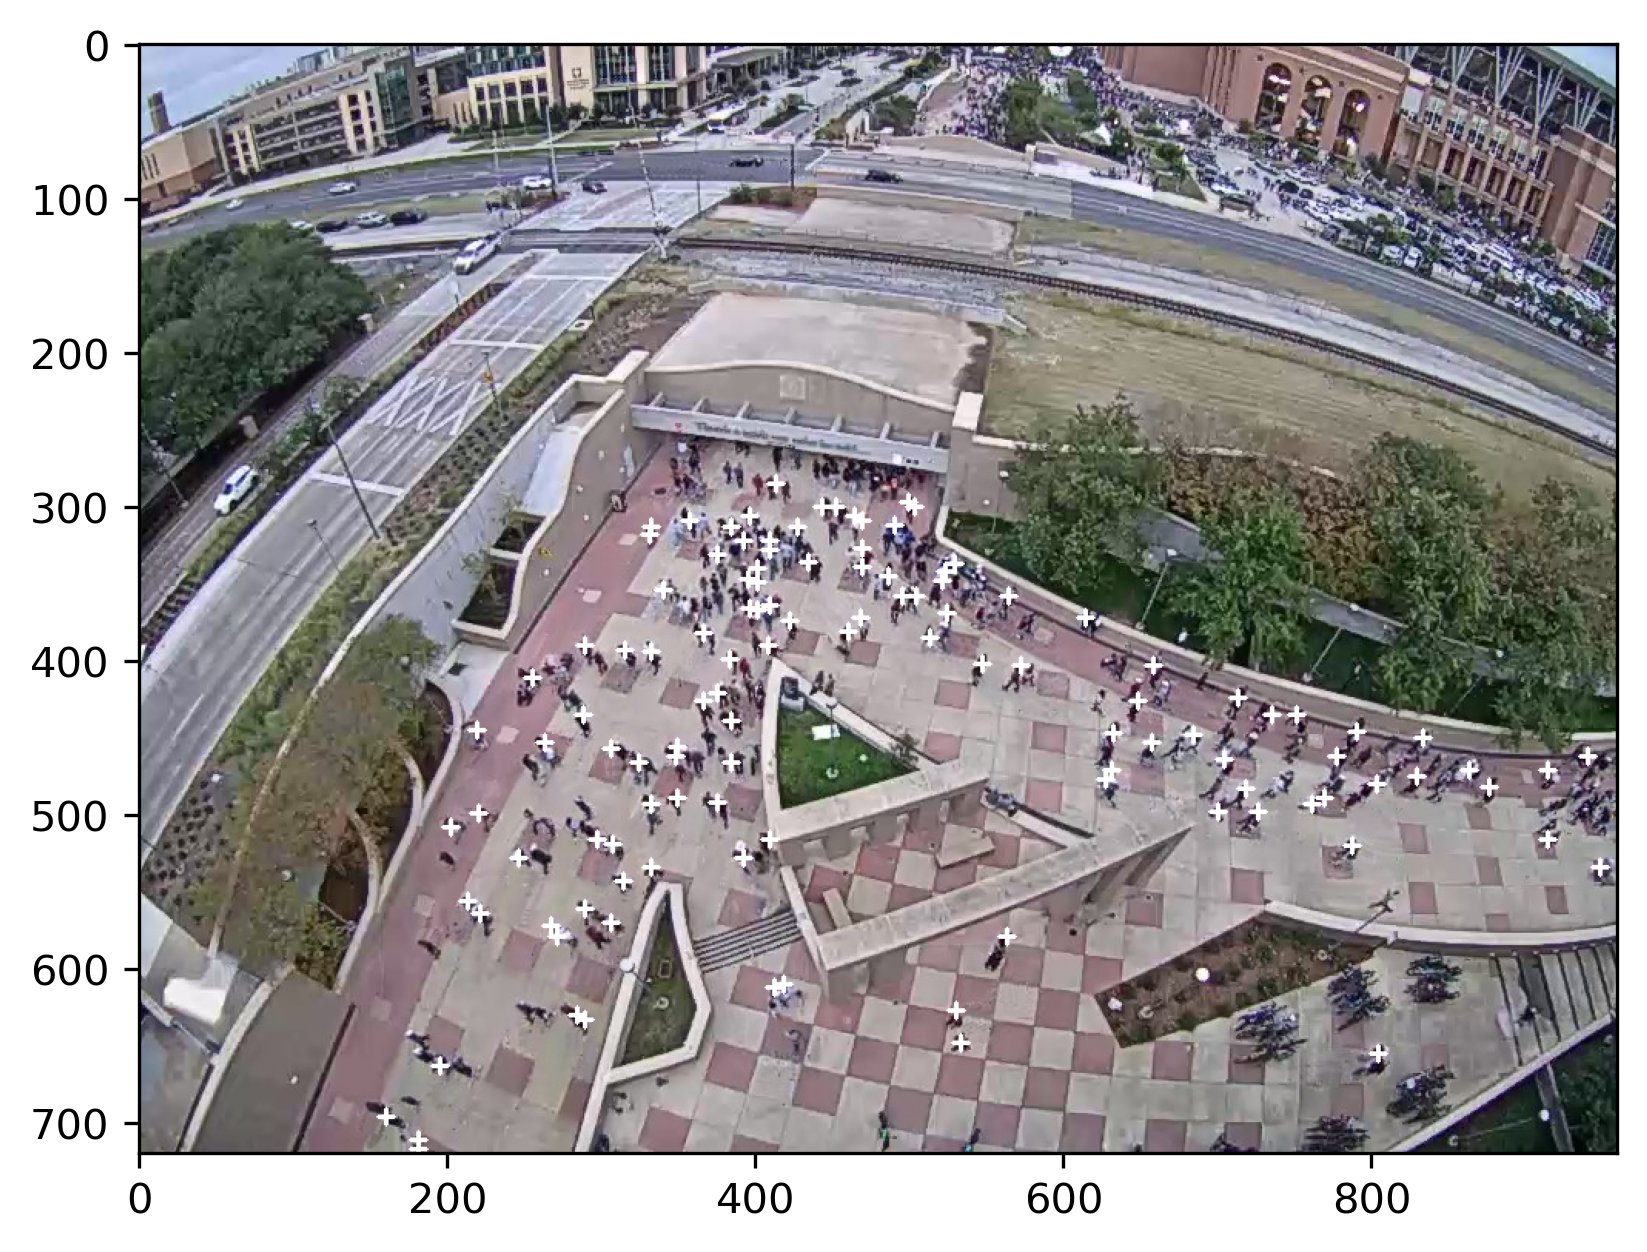

In [18]:
torch.cuda.empty_cache()

img_path='C:/Users/piyalong/Pictures/WCG _ P6 NE Corner UFO - Camera - 01-2022-10-29_17h00min00s000ms - frame at 52m49s.jpg'
# img_path='C:/Users/piyalong/Pictures/vecteezy_people-eat-in-the-cafe-and-go-up-and-down-on-the-escalator_28300306 - frame at 0m1s.jpg'
# img_path='C:/Users/piyalong/Pictures/diffusionpedestrian.png'

img_raw = cv2.imread(img_path)
# cv2.imwrite('sample1.jpg',img_raw)
img_raw=cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

# round the size
height,width = img_raw.shape[:2]
new_height=height // 128 * 128
new_width=width // 128 * 128

im=cv2.resize(img_raw, (new_width, new_height)) 

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

    # transforms.Resize((new_width, new_height)),
])

img = transform(im)
samples = img.unsqueeze(0).to(device)
outputs=model(samples)

outputs_points = outputs['pred_points'][0]
outputs_scores = torch.nn.functional.softmax(outputs['pred_logits'], -1)[:, :, 1][0]

threshold = 0.2
# filter the predictions
points = outputs_points[outputs_scores > threshold].detach().cpu().numpy()
scores= outputs_scores[outputs_scores > threshold].detach().cpu().numpy()
detections=point_nms(points,scores)
points=detections[:,:2]
points_scaled_back=points*np.array([width/new_width,height/new_height])

# draw the predictions
for p in points_scaled_back:
    cv2.drawMarker(img_raw, (int(p[0]), int(p[1])), (255, 255, 255), cv2.MARKER_CROSS, markerSize=10,thickness=2)

fig, ax = plt.subplots(dpi=300)
plt.imshow(img_raw)
# plt.savefig("pedestrian_detection.png")  # You can change the file extension to the desired format (e.g., jpg, pdf, etc.)


In [ ]:
points

In [20]:
detections[:,:2].shape

(119, 2)

# Process the video and get the prediction points

In [38]:
video_path='C:/Users/piyalong/Traffic Management/Bahareh Data/1minute video_1.mp4'


In [ ]:
# video_path = 'WCG  P6 NE Corner UFO - Camera - 01-2023-09-16_18h00min00s000m/WCG _ P6 NE Corner UFO - Camera - 01.mp4'

cap = cv2.VideoCapture(video_path)
# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

new_width = frame_width // 128 * 128
new_height = frame_height // 128 * 128
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for mp4 format

out = cv2.VideoWriter(video_path[:-4]+'_P2PNet.mp4', fourcc, fps, (new_width, new_height))

data={}
frame_number=0
while cap.isOpened() and cap.get(cv2.CAP_PROP_POS_FRAMES) <= total_frames:
    ret, frame = cap.read()  # frame shape 640*480*3
    if ret != True:
        break
    img_raw=cv2.resize(frame, (new_width, new_height)) 
    
    img=cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
    img = transform(img)
    samples = img.unsqueeze(0)
    outputs=model(samples.to(device))
    
    outputs_points = outputs['pred_points'][0]
    outputs_scores = torch.nn.functional.softmax(outputs['pred_logits'], -1)[:, :, 1][0]
    
    threshold = 0.1
    # filter the predictions
    points = outputs_points[outputs_scores > threshold].detach().cpu().numpy()
    scores= outputs_scores[outputs_scores > threshold].detach().cpu().numpy()

    detections=point_nms(points,scores)
    # draw the predictions
    for p in detections:
        cv2.drawMarker(img_raw, (int(p[0]), int(p[1])), (255, 255, 255), cv2.MARKER_CROSS, markerSize=10,thickness=2)

    # cv2.putText(img_raw,"Crowd Estimation: "+str(len(points)), (100,100), cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 3)
    print(frame_number,len(points))
    cv2.imshow("Output", img_raw)
    out.write(img_raw) 
    data.update({frame_number:detections})
    frame_number+=1
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
out.release()
cv2.destroyAllWindows()


In [ ]:
np.save(video_path[:-4]+'.npy',data)

In [28]:
data=np.load('D:/1minute video_1_1.npy',allow_pickle=True).item()

In [29]:
np.set_printoptions(suppress=True)

In [30]:
data[6]

array([[1021.12476   ,  363.12613   ,    0.16125298],
       [ 817.3872    ,  392.24182   ,    0.11046145],
       [ 806.3184    ,  405.96564   ,    0.17829046],
       [ 809.06287   ,  400.8179    ,    0.13594536],
       [ 813.6573    ,  402.89017   ,    0.10842522],
       [ 894.1324    ,  406.18906   ,    0.22273031],
       [ 902.3222    ,  405.78375   ,    0.15633614],
       [ 806.67426   ,  413.81854   ,    0.13467863],
       [ 877.8123    ,  411.39337   ,    0.2958025 ],
       [ 917.62024   ,  411.53903   ,    0.169192  ],
       [ 701.34216   ,  418.94916   ,    0.1787809 ],
       [ 800.7503    ,  416.77908   ,    0.10654566],
       [ 849.3185    ,  416.7798    ,    0.11028861],
       [ 994.51715   ,  421.07892   ,    0.15059705],
       [ 857.49695   ,  424.45963   ,    0.15698233],
       [ 861.83966   ,  427.0267    ,    0.26296845],
       [ 897.7379    ,  423.89056   ,    0.1271773 ],
       [ 901.75525   ,  427.27036   ,    0.20081018],
       [ 817.1671    ,  432.

In [31]:
def associate_detections_to_trackers (tracks,detections,distance_threshold=10): 
    if(len(tracks)==0):
        return np.empty((0,2),dtype=int), np.arange(len(detections)), np.empty((0,5),dtype=int)
    cost_matrix = cdist(tracks,detections)
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    
    unmatched_detections, unmatched_tracks = [], []

    for d in range(detections.shape[0]):
        if d not in col_indices:
            unmatched_detections.append(d)

    for t in range(tracks.shape[0]):
        if t not in row_indices:
            unmatched_tracks.append(t)

    # filter out matched with high distance between centroids
    matches = []
    for  t,d in zip(row_indices, col_indices):
        if cost_matrix[t, d] > distance_threshold:
            unmatched_detections.append(d)
            unmatched_tracks.append(t)
        else:
            matches.append((t,d))

    if len(matches):
        matches = np.array(matches)
    else:
        matches = np.empty((0, 2), dtype=int)

    return matches, np.array(unmatched_detections), np.array(unmatched_tracks)

In [32]:
new_width, new_height

(1408, 1024)

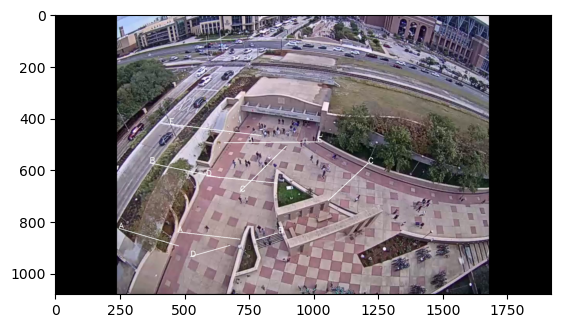

In [42]:
import json
pixelshapes={}

json_path="D:/via_project_7Oct2023_19h29m_json (2).json"

# Open the JSON file for reading
with open(json_path, "r") as json_file:
    # Load the JSON data into a Python dictionary
    json_data = json.load(json_file)

    for each in json_data[list(json_data.keys())[0]]['regions']:
        each_name=each['region_attributes']['checkline']
        all_x=each['shape_attributes']['all_points_x']
        all_y=each['shape_attributes']['all_points_y']
        start_point = all_x[0],all_y[0]
        end_point = all_x[1],all_y[1]

        pixelshapes.update({each_name:[start_point,end_point]})
        
for name,check_shape in pixelshapes.items():

    cv2.line(img_raw,check_shape[0],check_shape[1],(255,255,255),2)
    cv2.putText(img_raw,name,check_shape[0],cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    
plt.imshow( cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))

In [34]:
cv2.destroyAllWindows()

# track and count with checklines

In [50]:
pixelshapes

{'A': [(475, 840), (716, 868)],
 'B': [(863, 844), (776, 871)],
 'C': [(1212, 575), (1057, 719)],
 'D': [(585, 624), (860, 652)],
 'E': [(1016, 493), (654, 496)]}

In [44]:
class Point:
	def __init__(self,x,y):
		self.x = x
		self.y = y

def ccw(A,B,C):
	return (C.y-A.y)*(B.x-A.x) > (B.y-A.y)*(C.x-A.x)

def intersect(A,B,C,D):
	return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def check_cross(checkline, traj_line):
    
    previous_x,previous_y = traj_line[1][0],traj_line[1][1]
    next_x,next_y = traj_line[0][0],traj_line[0][1]
    
    return intersect(Point(previous_x,previous_y), Point(next_x,next_y),Point(checkline[0][0],checkline[0][1]),Point(checkline[1][0],checkline[1][1]))


In [45]:
new_width,width

(1408, 1920)

In [46]:
from shapely.geometry import Point as P
from shapely.geometry.polygon import LinearRing, Polygon

In [47]:
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
ID=0
tracks={}
frame_number=0
file_path = 'D:/drive-download-20231006T190238Z-001/WCG  P6 NE Corner UFO - Camera - 01-2023-09-16_18h00min00s000m//WCG _ P6 NE Corner UFO - Camera - 01.mp4'

video_capture = cv2.VideoCapture(video_path)
width= int(video_capture.get(3))
height = int(video_capture.get(4))
fps = int(video_capture.get(cv2.CAP_PROP_FPS))
new_width = width // 128 * 128
new_height =height // 128 * 128
out = cv2.VideoWriter(file_path[:-4]+'_Count.avi', cv2.VideoWriter_fourcc(*'XVID'), fps, (width, height))

# tracks_to_save={}
total_count = {i:{} for i in pixelshapes.keys()}

while True:
    ret, frame = video_capture.read()  # frame shape 640*480*3
    if ret != True:
        break
    # img=img_raw
    # img=cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
    dict_copy = tracks.copy()
    
    points=data[frame_number][:,:2]
    points_scaled_back=points*np.array([width/new_width,height/new_height])
    
    detections=points_scaled_back
    # detections = np.array([points_scaled_back[:,0],points_scaled_back[:,1], scores]).T
    
    tracks_list = np.array([v[-1][:2] for k,v in tracks.items()])
    matches, unmatched_detections, unmatched_tracks = associate_detections_to_trackers(tracks_list,detections)
    
    for i in range(matches.shape[0]):
        t, d = matches[i, :]
        point = detections[d, :2]
        track = tracks_list[t, :2]
        # print(point)
        for key, value in dict_copy.items() :
            
            # print(key,value)
            if list(track)==value[-1][:2]:
                tracks[key].append([point[0],point[1],frame_number])
                # tracks_to_save[key].append([point[0],point[1],frame_number])
    for d in unmatched_detections:
        point = detections[d, :2]
        # confidence = detections[d,2]
        ID+=1
        tracks.update({ID:[]}) 
        # tracks_to_save.update({ID:[]}) 
        tracks[ID].append([point[0],point[1],frame_number])
        # tracks_to_save[ID].append([point[0],point[1],frame_number])
    for t in unmatched_tracks:
        track = tracks_list[t, :2]
        for key, value in dict_copy.items() :
            # print(key,value)
            if list(track)==value[-1][:2]:
                del tracks[key]

    for name,checkline in pixelshapes.items():
        total_count[name][frame_number]=0
        cv2.line(frame,checkline[0],checkline[1],(0,255,255),2)
        cv2.putText(frame,name+':',(checkline[0][0]-50,checkline[0][1]),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,255),2)
        total_per_line=sum(total_count[name].values())
        cv2.putText(frame,str(total_per_line),checkline[0],cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,255),2)
    
    for ID,p in tracks.items():
        x1,y1 ,fn= [int(x) for x in p[-1]]
           
        if fn==frame_number:
            cv2.drawMarker(frame, (x1, y1), (255, 255, 255), cv2.MARKER_CROSS, markerSize=10,thickness=2)
            cv2.putText(frame,str(ID),(x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
            if len(p)>=2:
                x2,y2,fn2= [int(x) for x in p[-2]]
                traj_line = [[x1,y1],[x2,y2]]
                
                for name,checkline in pixelshapes.items():
                    if check_cross(checkline,traj_line) :
                        total_count[name][frame_number]+=1
    cv2.imshow("Output", frame)
    # out.write(frame) 
    frame_number+=1
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    # if frame_number>800:break
cv2.destroyAllWindows()

In [ ]:
total_count

<Axes: xlabel='Time'>

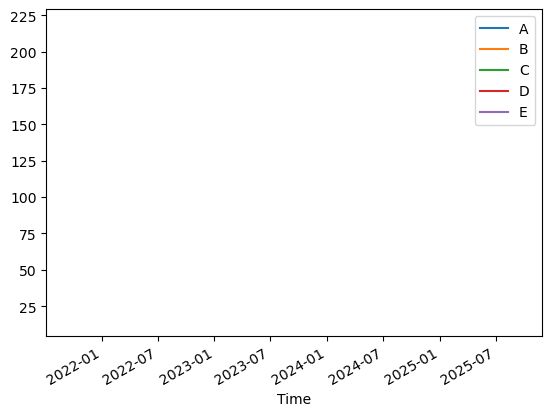

In [53]:
import pandas as pd
import datetime

#get time from file path name
txt='WCG  P6 NE Corner UFO - Camera - 01-2023-09-16_18h00min00s000m'
date = txt[txt.find("min")-16:txt.find("min")-6]
hrs = txt[txt.find("min")-5:txt.find("min")-3]
minute = txt[txt.find("min")-2:txt.find("min")]
second = txt[txt.find("min")+3:txt.find("min")+5]
t = pd.to_datetime(date+' '+hrs+':'+minute+':'+second)

df_total=pd.DataFrame(total_count)

time_seconds=[]

for frame_number in df_total.index:

    current_t = t + datetime.timedelta(0,frame_number/fps)
    time_seconds.append(current_t)
    
df_total['Time'] = pd.to_datetime(time_seconds)

agg_df = df_total.groupby(pd.Grouper(key='Time', freq='5T')).agg({
    'A': 'sum',
    'B': 'sum',
    'C': 'sum',
    'D': 'sum',
    'E': 'sum'
}).reset_index()

agg_df.set_index('Time', inplace=True)
# Display the aggregated DataFrame

agg_df.plot()